In [23]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io

# Load image
image_path = r"C:\Users\noorh\Echocardiograms\mats\Mask_ES00018 _4CH_1\frame_0.png"
image = io.imread(image_path)


binary_image = image > 0
height, width = binary_image.shape

In [24]:
# Identify bottom-most pixel on the left half of the shape
left_half = binary_image[:, :width//2]
bottom_left_y, bottom_left_x = np.argwhere(left_half)[-1]

# Identify bottom-most pixel on the right half of the shape 
right_half = binary_image[:, width//2:]
bottom_right_y, bottom_right_x = np.argwhere(right_half)[-1]
bottom_right_x += width // 2  

# Trace Bottom Border
bottom_border_trace = []
for x in range(bottom_left_x, bottom_right_x + 1):
    column = np.argwhere(binary_image[:, x])
    if column.size > 0:
        y = column[-1, 0]
        bottom_border_trace.append((x, y))

# Identify the apex
bottom_border_trace = np.array(bottom_border_trace)
apex_index = np.argmin(bottom_border_trace[:, 1])
apex = bottom_border_trace[apex_index]

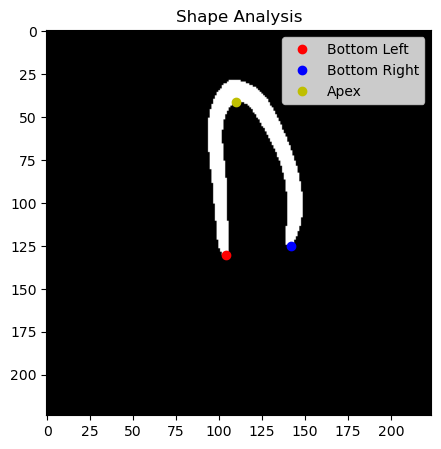

In [25]:
plt.figure(figsize=(10, 5))
plt.imshow(binary_image, cmap='gray')
plt.plot(bottom_left_x, bottom_left_y, 'ro', label='Bottom Left')
plt.plot(bottom_right_x, bottom_right_y, 'bo', label='Bottom Right')
plt.plot(apex[0], apex[1], 'yo', label='Apex')
plt.legend()
plt.title('Shape Analysis')
plt.show()

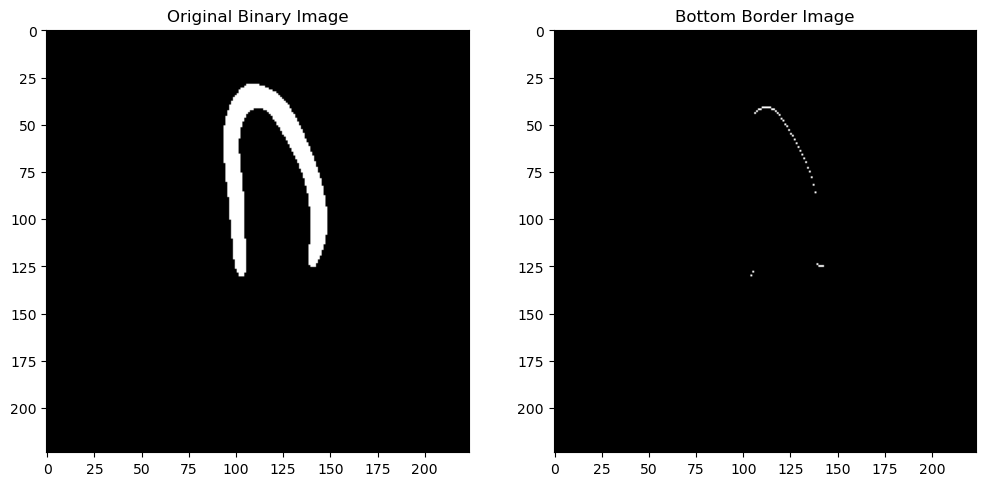

In [26]:
border_trace_image = np.zeros_like(binary_image)

for x, y in bottom_border_trace:
    border_trace_image[y, x] = 1

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(binary_image, cmap='gray')
ax[0].set_title('Original Binary Image')
ax[1].imshow(border_trace_image, cmap='gray')
ax[1].set_title('Bottom Border Image')
plt.show()

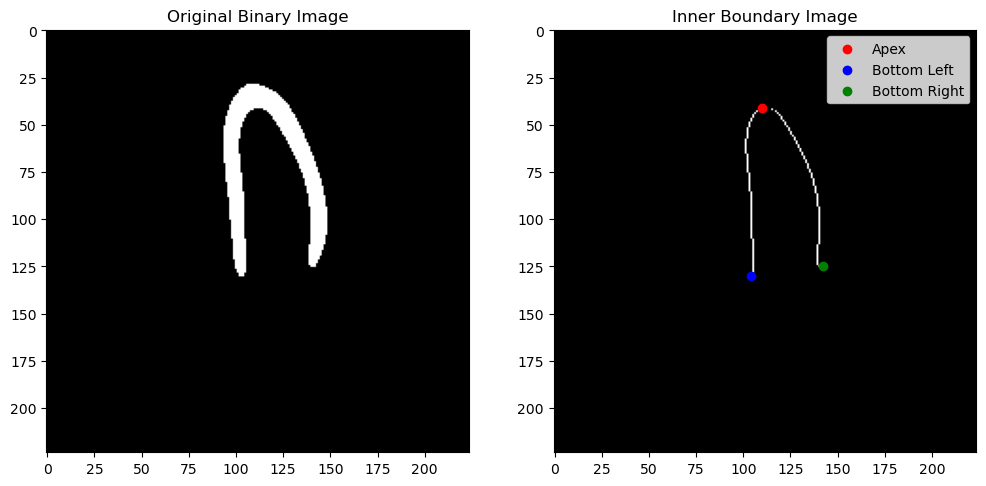

In [27]:
# Extract inner boundary / bottom border
#############################################################################
# Divide the image into two halves at the apex point
apex_x = apex[0]

# For the left half, get the rightmost pixel in each row
left_half_pixels = []
for y in range(height):
    row = np.argwhere(binary_image[y, :apex_x])
    if row.size > 0:
        left_half_pixels.append((row[-1, 0], y))

# For the right half, get the leftmost pixel in each row
right_half_pixels = []
for y in range(height):
    row = np.argwhere(binary_image[y, apex_x:])
    if row.size > 0:
        right_half_pixels.append((row[0, 0] + apex_x, y))

# Combine 
new_image = np.zeros_like(binary_image)

inner_boundary = []

for x, y in left_half_pixels + right_half_pixels:
    if y >= apex[1]:
        new_image[y, x] = 1
        inner_boundary.append((x, y))

new_image[apex[1], apex[0]] = 1
new_image[bottom_left_y, bottom_left_x] = 1
new_image[bottom_right_y, bottom_right_x] = 1

inner_boundary.append((apex[0], apex[1]))
inner_boundary.append((bottom_left_x, bottom_left_y))
inner_boundary.append((bottom_left_x, bottom_left_y))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(binary_image, cmap='gray')
ax[0].set_title('Original Binary Image')
ax[1].imshow(new_image, cmap='gray')
ax[1].set_title('Inner Boundary Image')
plt.scatter([apex[0]], [apex[1]], color='red', label='Apex')
plt.scatter([bottom_left_x], [bottom_left_y], color='blue', label='Bottom Left')
plt.scatter([bottom_right_x], [bottom_right_y], color='green', label='Bottom Right')
plt.legend()
plt.show()

In [15]:
# Calculate R and L
R = bottom_right_y - apex[1]
L = bottom_left_y - apex[1]
(bottom_right_y, bottom_left_y, apex[1], R, L)

(125, 130, 41, 84, 89)

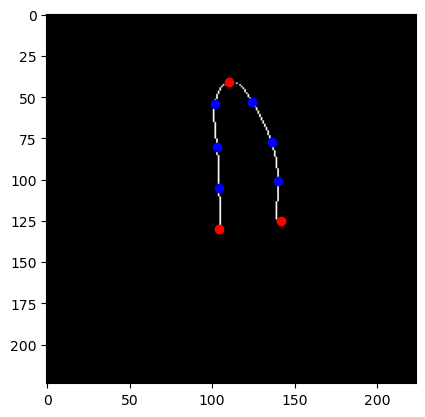

In [16]:
# Identify section end-points S1, S2, S3, S5, S6, S7
S1 = next((point for point in inner_boundary if point[0] < apex[0] and point[1] == bottom_left_y - 2 * L // 7), None)
S2 = next((point for point in inner_boundary if point[0] < apex[0] and point[1] == bottom_left_y - 4 * L // 7), None)
S3 = next((point for point in inner_boundary if point[0] < apex[0] and point[1] == bottom_left_y - 6 * L // 7), None)
S7 = next((point for point in inner_boundary if point[0] > apex[0] and point[1] == bottom_right_y - 2 * R // 7), None)
S6 = next((point for point in inner_boundary if point[0] > apex[0] and point[1] == bottom_right_y - 4 * R // 7), None)
S5 = next((point for point in inner_boundary if point[0] > apex[0] and point[1] == bottom_right_y - 6 * R // 7), None)
(S1, S2, S3, S7, S6, S5)

plt.imshow(new_image, cmap='gray')
plt.scatter([bottom_left_x, bottom_right_x, apex[0]], [bottom_left_y, bottom_right_y, apex[1]], color='red')
for s in [S1, S2, S3, S5, S6, S7]:
    if s is not None:
        plt.scatter(s[0], s[1], color='blue')
plt.show()

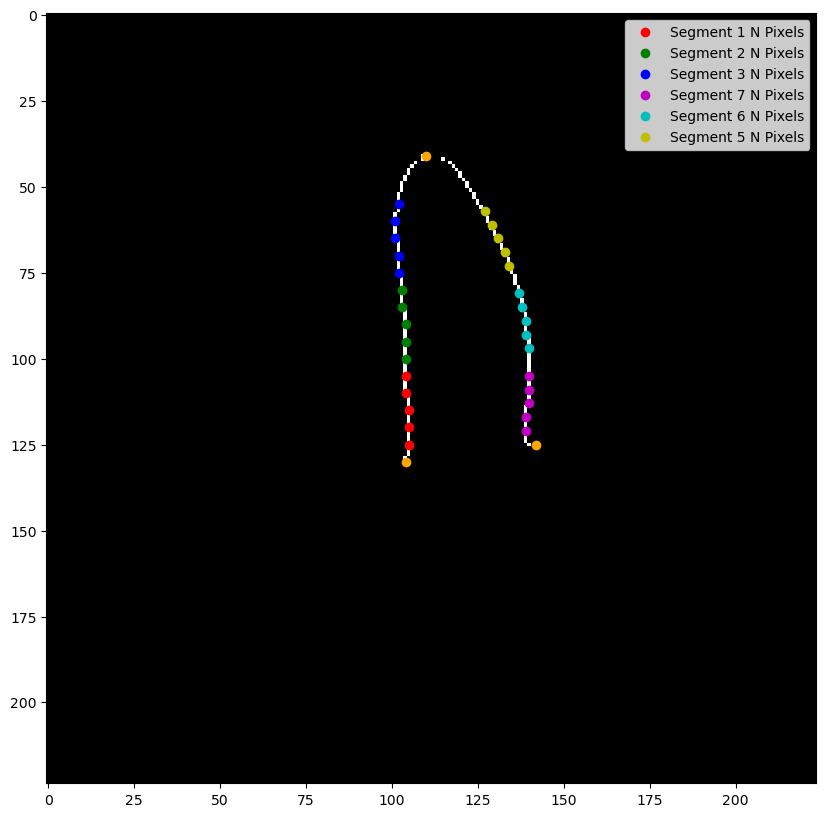

In [30]:
# Get N equally spaced pixels in each section
N = 5 
left_length = (2 * L // 7) // N
right_length = (2 * R // 7) // N

segment1 = []
segment2 = []
segment3 = []
segment7 = []
segment6 = []
segment5 = []

def get_leftside_N_points(bottom_point):
    points = []
    for i in range(N):
        point = next((point for point in inner_boundary if point[0] < apex[0] and point[1] == (bottom_point[1] - ((i + 1) * left_length))), None)
        points.append(point)
    return points

def get_rightside_N_points(bottom_point):
    points = []
    for i in range(N):
        point = next((point for point in inner_boundary if point[0] > apex[0] and point[1] == (bottom_point[1] - ((i + 1) * right_length))), None)
        points.append(point)
    return points

segment1 = get_leftside_N_points((bottom_left_x, bottom_left_y))
segment2 = get_leftside_N_points(S1)
segment3 = get_leftside_N_points(S2)

segment7 = get_rightside_N_points((bottom_right_x, bottom_right_y))
segment6 = get_rightside_N_points(S7)
segment5 = get_rightside_N_points(S6)

plt.figure(figsize=(10, 10))
plt.imshow(new_image, cmap='gray')
plt.plot(*zip(*segment1), 'ro', label='Segment 1 N Pixels')
plt.plot(*zip(*segment2), 'go', label='Segment 2 N Pixels')
plt.plot(*zip(*segment3), 'bo', label='Segment 3 N Pixels')
plt.plot(*zip(*segment7), 'mo', label='Segment 7 N Pixels')
plt.plot(*zip(*segment6), 'co', label='Segment 6 N Pixels')
plt.plot(*zip(*segment5), 'yo', label='Segment 5 N Pixels')
plt.scatter([bottom_left_x, bottom_right_x, apex[0]], [bottom_left_y, bottom_right_y, apex[1]], color='orange')
plt.legend()
plt.show()

In [18]:
print(f"Results:")
print(f"Segment1: {segment1}")
print(f"Segment2: {segment2}")
print(f"Segment3: {segment3}")
print(f"Segment7: {segment7}")
print(f"Segment6: {segment6}")
print(f"Segment5: {segment5}")

Results:
Segment1: [(105, 125), (105, 120), (105, 115), (104, 110), (104, 105)]
Segment2: [(104, 100), (104, 95), (104, 90), (103, 85), (103, 80)]
Segment3: [(102, 75), (102, 70), (101, 65), (101, 60), (102, 55)]
Segment7: [(139, 121), (139, 117), (140, 113), (140, 109), (140, 105)]
Segment6: [(140, 97), (139, 93), (139, 89), (138, 85), (137, 81)]
Segment5: [(134, 73), (133, 69), (131, 65), (129, 61), (127, 57)]
